In [36]:
import numpy as np
import pandas as pd
import datetime as dt
import statsmodels.api as sm
import matplotlib.pyplot as plt
#import matplotlib.dates as mdates
from matplotlib.dates import DayLocator, DateFormatter

In [2]:
humidity = pd.read_excel('/Volumes/Seagate Backup Plus Drive/data_exp1/ELTE_10min_calib.xlsx')

In [3]:
humidity.columns  # columns in humidity data

Index(['TIMESTAMP_UTC', 'RH1_BME_10min', 'RH2_BME_10min', 'RH_roof_10min',
       'ELTE_rh_Avg(1)', 'ELTE_rh_Avg(2)', 'RH_OMSZ_10min', 'ROOF_original',
       'ROOF_+6.4', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12',
       'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16',
       'Unnamed: 17', 'Unnamed: 18'],
      dtype='object')

In [4]:
humidity = humidity[['TIMESTAMP_UTC', 'RH1_BME_10min', 'RH2_BME_10min', 'RH_roof_10min', 'ELTE_rh_Avg(1)',
                    'ELTE_rh_Avg(2)', 'RH_OMSZ_10min']]

In [5]:
humidity['TIMESTAMP_UTC'] = pd.to_datetime(humidity['TIMESTAMP_UTC'])

In [6]:
synop = pd.read_excel('/Users/varungandhi/Downloads/Budapest-44527-10-perces.xlsx')

In [7]:
synop.columns

Index(['idő (CET)', 'T', 'U', 'P', 'FS', 'FSD', 'R', 'V', 'SR', 'SREF', 'SAL',
       'SSUL', 'ET10', 'ET20', 'ET50', 'ET100', 'EU10', 'EU20', 'EU50'],
      dtype='object')

In [8]:
synop = synop[['idő (CET)', 'V', 'U', 'T', 'FS']]

In [9]:
synop = synop.rename(columns = {'idő (CET)':'Time (CET)'})

In [10]:
print(synop.shape, humidity.shape)

(28368, 5) (23727, 7)


In [11]:
print(synop['Time (CET)'], humidity['TIMESTAMP_UTC'])

0        2020-11-01 00:10:00
1        2020-11-01 00:20:00
2        2020-11-01 00:30:00
3        2020-11-01 00:40:00
4        2020-11-01 00:50:00
                ...         
28363    2021-05-16 23:20:00
28364    2021-05-16 23:30:00
28365    2021-05-16 23:40:00
28366    2021-05-16 23:50:00
28367    2021-05-17 00:00:00
Name: Time (CET), Length: 28368, dtype: object 0       2020-11-20 16:30:00
1       2020-11-20 16:40:00
2       2020-11-20 16:50:00
3       2020-11-20 17:00:00
4       2020-11-20 17:10:00
                ...        
23722   2021-05-04 10:10:00
23723   2021-05-04 10:20:00
23724   2021-05-04 10:30:00
23725   2021-05-04 10:40:00
23726   2021-05-04 10:50:00
Name: TIMESTAMP_UTC, Length: 23727, dtype: datetime64[ns]


In [12]:
synop = synop[(synop['Time (CET)'] >= '2020-11-20 16:40:00') & (synop['Time (CET)'] <= '2021-03-31 23:50:00')]
humidity = humidity[(humidity['TIMESTAMP_UTC'] >= '2020-11-20 16:40:00 ') & (humidity['TIMESTAMP_UTC'] <= '2021-03-31 23:50:00')]

In [13]:
x = synop['U'].to_numpy()
y = humidity['RH_OMSZ_10min'].to_numpy()
len(x)

18908

In [14]:
xx = x[6:len(x)]
yy = y[0:len(y)-6]
shift = sm.tsa.stattools.ccf(xx, yy, adjusted=False)

In [15]:
np.argmax(shift)

0

In [16]:
synop = synop.reset_index()
humidity = humidity.reset_index()

In [17]:
synop = synop.iloc[6:, 1:]
humidity = humidity.iloc[0:len(humidity['TIMESTAMP_UTC']) -6 ,1:]

In [18]:
synop = synop.reset_index()
humidity = humidity.reset_index()

In [19]:
combined = pd.concat([humidity, synop], axis = 1)
combined_1 = combined.iloc[:,1:8]
combined_2 = combined.iloc[:, 9:]

In [20]:
combined_all = pd.concat([combined_1, combined_2], axis = 1)
combined_all = combined_all.set_index(combined_all['TIMESTAMP_UTC'])

In [21]:
combined_all.columns

Index(['TIMESTAMP_UTC', 'RH1_BME_10min', 'RH2_BME_10min', 'RH_roof_10min',
       'ELTE_rh_Avg(1)', 'ELTE_rh_Avg(2)', 'RH_OMSZ_10min', 'Time (CET)', 'V',
       'U', 'T', 'FS'],
      dtype='object')

In [166]:
def visibility(lower_value, upper_value,value):
    list_empty = []
    for i in range(len(combined_all['V'])):
        if combined_all['V'][i] >= lower_value and combined_all['V'][i] <= upper_value:
            list_empty.append(value)
        
        else:
            list_empty.append(float('NAN'))
            
    return list_empty

Vis_1000 = visibility( 0, 1000, 60)
Vis_500 = visibility( 0, 500, 80)
Vis_2000 = visibility( 0, 2000, 50)
Vis_5000 = visibility( 0, 5000, 45)
combined_all['Vis_1000'] = Vis_1000
combined_all['Vis_2000'] = Vis_2000
combined_all['Vis_5000'] = Vis_5000
combined_all['Vis_500'] = Vis_500

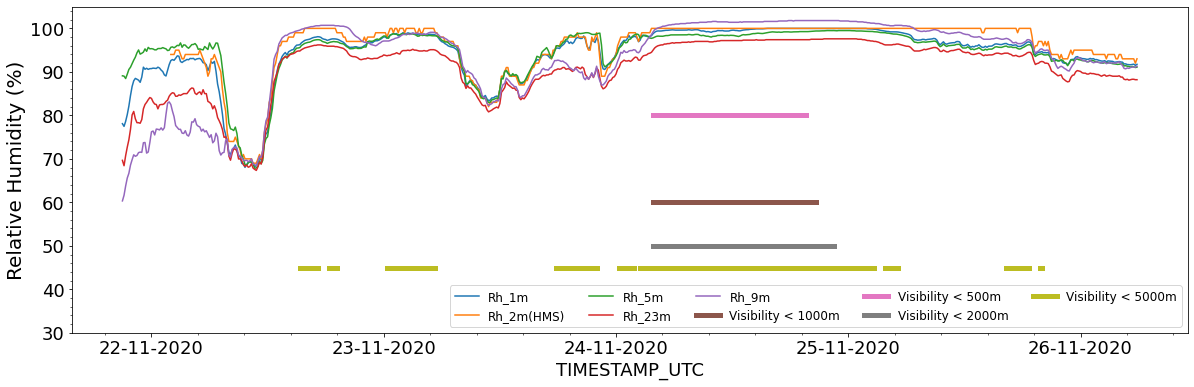

In [183]:
fig, ax = plt.subplots(1)

plt.rcParams["figure.figsize"] = (20,6)
####relative humidities
ax.plot(combined_all['RH1_BME_10min'][170:800], label = 'Rh_1m')
ax.plot(combined_all['U'][200:800], label = 'Rh_2m(HMS)')
ax.plot(combined_all['RH2_BME_10min'][170:800], label = 'Rh_5m')
ax.plot(combined_all['ELTE_rh_Avg(1)'][170:800], label = 'Rh_23m')
ax.plot(combined_all['ELTE_rh_Avg(2)'][170:800], label = 'Rh_9m')

#### visbilities
ax.plot(combined_all['Vis_1000'][170:800], linewidth=5, label = 'Visibility < 1000m')
ax.plot(combined_all['Vis_500'][170:800], linewidth=5, label = 'Visibility < 500m')
ax.plot(combined_all['Vis_2000'][170:800], linewidth=5, label = 'Visibility < 2000m')
ax.plot(combined_all['Vis_5000'][170:800], linewidth=5, label = 'Visibility < 5000m')




ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=8)
ax.tick_params(axis='x', labelrotation=0)

ax.set_ylim([30,105])
ax.set_yticks(np.arange(30,105, 10.0))

ax.legend(loc= 'lower right', prop={'size': 12}, ncol = 5)
ax.set_xlabel('TIMESTAMP_UTC', fontsize=18)
ax.set_ylabel('Relative Humidity (%)', fontsize=20)

ax.minorticks_on()
ax.xaxis.set_major_locator(DayLocator())
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%Y"))

#fig.savefig('/Volumes/Seagate Backup Plus Drive/data_exp1/case_nov_rh.png')

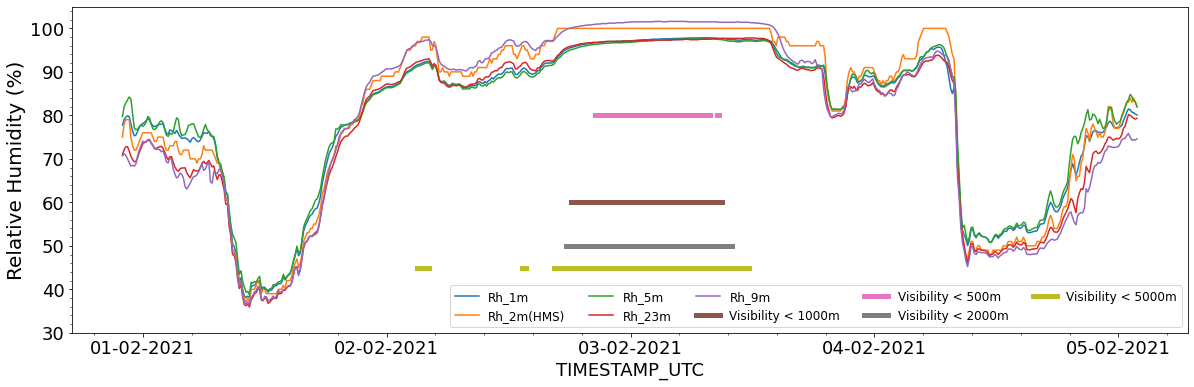

In [184]:
fig, ax = plt.subplots(1)
plt.rcParams["figure.figsize"] = (20,6)

ax.plot(combined_all['RH1_BME_10min'][10400:11000], label = 'Rh_1m')
ax.plot(combined_all['U'][10400:11000], label = 'Rh_2m(HMS)')
ax.plot(combined_all['RH2_BME_10min'][10400:11000], label = 'Rh_5m')
ax.plot(combined_all['ELTE_rh_Avg(1)'][10400:11000], label = 'Rh_23m')
ax.plot(combined_all['ELTE_rh_Avg(2)'][10400:11000], label = 'Rh_9m')



ax.plot(combined_all['Vis_1000'][10400:11000], linewidth=5, label = 'Visibility < 1000m')
ax.plot(combined_all['Vis_500'][10400:11000], linewidth=5, label = 'Visibility < 500m')
ax.plot(combined_all['Vis_2000'][10400:11000], linewidth=5, label = 'Visibility < 2000m')
ax.plot(combined_all['Vis_5000'][10400:11000], linewidth=5, label = 'Visibility < 5000m')

ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='x', which='minor', labelsize=8, bottom = 'on')
ax.tick_params(axis='x', labelrotation=0)


ax.set_ylim([30,105])
ax.set_yticks(np.arange(30,105, 10.0))

ax.legend(loc= 'lower right', prop={'size': 12}, ncol = 5)
ax.set_xlabel('TIMESTAMP_UTC', fontsize=18)
ax.set_ylabel('Relative Humidity (%)', fontsize=20)

ax.xaxis.set_major_locator(DayLocator())
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%Y"))

ax.minorticks_on()


#ax.xaxis.set_minor_locator(DayLocator())
#ax.xaxis.set_minor_formatter(DateFormatter("%Y-%m-%d"))
#fig.savefig('/Volumes/Seagate Backup Plus Drive/data_exp1/case_feb_rh.png')

In [56]:
temp_gill_1 = pd.read_excel('/Volumes/Seagate Backup Plus Drive/data_exp1/CR1000_10min.xlsx', skiprows = 1, sheet_name = 'Nov & Dec')
temp_gill_2 = pd.read_excel('/Volumes/Seagate Backup Plus Drive/data_exp1/CR1000_10min.xlsx', skiprows = 1, sheet_name = 'January')
temp_gill_3 = pd.read_excel('/Volumes/Seagate Backup Plus Drive/data_exp1/CR1000_10min.xlsx', skiprows = 1, sheet_name = 'February')
temp_gill_4 = pd.read_excel('/Volumes/Seagate Backup Plus Drive/data_exp1/CR1000_10min.xlsx', skiprows = 1, sheet_name = 'March')

temp_gill_4 = temp_gill_4.iloc[:, 0:12]
temp_gill_5 = pd.read_excel('/Volumes/Seagate Backup Plus Drive/data_exp1/CR1000_10min.xlsx', skiprows = 1, sheet_name = 'April')


In [57]:
temp_gill_nov = temp_gill_1
temp_gill_nov.reset_index(inplace = True)


In [58]:
temp_gill = pd.concat([temp_gill_3, temp_gill_4, temp_gill_5], axis = 0)

In [59]:

temp_gill = temp_gill[(temp_gill['TIMESTAMP'] >= '2021-02-01 00:00:00') & (temp_gill['TIMESTAMP'] <= '2021-05-04 12:50:00')]


In [60]:
temp_garden = pd.read_csv('/Volumes/Seagate Backup Plus Drive/data_exp1/temp_humi_garden.csv')
temp_garden = temp_garden[4:]
temp_garden['TIMESTAMP(UTC+2)'] = pd.to_datetime(temp_garden['TIMESTAMP(UTC+2)'])

temp_garden = temp_garden.resample('10min', closed = 'left', on = 'TIMESTAMP(UTC+2)').mean()

temp_garden['TIMESTAMP(UTCplus2)'] = temp_garden.index

In [61]:
temp_garden = temp_garden[(temp_garden['TIMESTAMP(UTCplus2)'] >= '2021-02-01 00:00:00') & 
                        (temp_garden['TIMESTAMP(UTCplus2)'] <= '2021-04-07 14:20:00')]


In [62]:
temp_garden.reset_index(inplace = True)

In [63]:
x = temp_gill['temp_Avg(1)'].to_numpy()
y = temp_garden['AirTC_2_Avg'].to_numpy()



xx = x
yy = y
shift = sm.tsa.stattools.ccf(xx, yy, adjusted=False)

In [64]:
temp_garden.columns

Index(['TIMESTAMP(UTC+2)', 'RECORD', 'AirTC_1_Avg', 'RH_1', 'AirTC_2_Avg',
       'RH_2', 'TIMESTAMP(UTCplus2)'],
      dtype='object')

In [65]:
temp_gill.columns

Index(['TIMESTAMP', 'RECORD', 'PTemp_Avg', 'Batt_volt_Avg', 'rh_Avg(1)',
       'rh_Avg(2)', 'temp_Avg(1)', 'temp_Avg(2)', 'ws_Avg(1)', 'ws_Avg(2)',
       'ws_Std(1)', 'ws_Std(2)'],
      dtype='object')

In [66]:
temp_garden.shape

(9447, 7)

In [67]:
temp_gill.shape

(9446, 12)

In [68]:
temp_gill.isna().sum()

TIMESTAMP        0
RECORD           0
PTemp_Avg        0
Batt_volt_Avg    0
rh_Avg(1)        0
rh_Avg(2)        0
temp_Avg(1)      0
temp_Avg(2)      0
ws_Avg(1)        0
ws_Avg(2)        0
ws_Std(1)        0
ws_Std(2)        0
dtype: int64

In [69]:
temp_garden.isna().sum()

TIMESTAMP(UTC+2)       0
RECORD                 0
AirTC_1_Avg            0
RH_1                   0
AirTC_2_Avg            0
RH_2                   0
TIMESTAMP(UTCplus2)    0
dtype: int64

In [70]:
temp_garden = temp_garden[0:9447]


In [71]:
temp_gill.reset_index(inplace = True)

In [72]:
#resetting
temp_gill_f = temp_gill.iloc[0:len(temp_gill['TIMESTAMP']) - 12, :]
temp_garden_f = temp_garden.iloc[12:len(temp_garden['TIMESTAMP(UTC+2)'])]


In [73]:
##resetting index again
temp_garden_f = temp_garden_f.reset_index()

In [74]:
synop_temp = synop[(synop['Time (CET)'] >= '2021-02-01 00:00:00') &
                  (synop['Time (CET)'] <= '2021-04-07 14:20:00')]
synop_temp = synop_temp.reset_index()

In [75]:
combined_temp = pd.concat([temp_gill_f, temp_garden_f, synop_temp], axis = 1)

In [76]:
combined_temp = combined_temp.set_index(combined_temp['TIMESTAMP'])  ## combining all the data for february

In [188]:
def visibility(lower_value, upper_value,value):
    list_empty = []
    for i in range(len(combined_temp['V'])):
        if combined_temp['V'][i] >= lower_value and combined_temp['V'][i] <= upper_value:
            list_empty.append(value)
        
        else:
            list_empty.append(float('NAN'))
            
    return list_empty

Vis_1000 = visibility( 0, 1000, 0)
Vis_500 = visibility( 0, 500, 4)
Vis_2000 = visibility( 0, 2000, 2)
Vis_5000 = visibility( 0, 5000, -1)
combined_temp['Vis_1000'] = Vis_1000
combined_temp['Vis_2000'] = Vis_2000
combined_temp['Vis_5000'] = Vis_5000
combined_temp['Vis_500'] = Vis_500

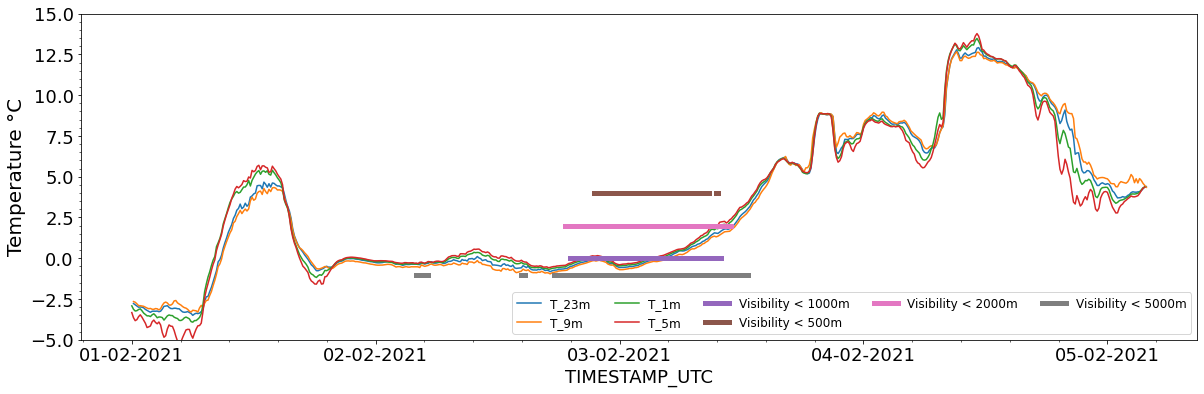

In [197]:
fig, ax = plt.subplots(1)
plt.rcParams["figure.figsize"] = (20,6)

ax.plot(combined_temp['temp_Avg(1)'][1:600], label = 'T_23m')
ax.plot(combined_temp['temp_Avg(2)'][1:600], label = 'T_9m')
#ax.plot(combined_temp['T'][0:600 -1], label = 'Rh_2m(HMS)')
ax.plot(combined_temp['AirTC_1_Avg'][0:600 -1], label = 'T_1m')
ax.plot(combined_temp['AirTC_2_Avg'][0:600 -1], label = 'T_5m')


# visibility


ax.plot(combined_temp['Vis_1000'][0:600], linewidth=5, label = 'Visibility < 1000m')
ax.plot(combined_temp['Vis_500'][0:600], linewidth=5, label = 'Visibility < 500m')
ax.plot(combined_temp['Vis_2000'][0:600], linewidth=5, label = 'Visibility < 2000m')
ax.plot(combined_temp['Vis_5000'][0:600], linewidth=5, label = 'Visibility < 5000m')

ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=8)
ax.tick_params(axis='x', labelrotation= 0)

ax.set_ylim([-5,15])
ax.legend(loc= 'lower right', prop={'size': 12}, ncol = 5)
ax.set_xlabel('TIMESTAMP_UTC', fontsize=18)
ax.set_ylabel('Temperature \N{DEGREE SIGN}C', fontsize=20)
#fig.savefig('/Volumes/Seagate Backup Plus Drive/data_exp1/case_feb_temp.png')

ax.xaxis.set_major_locator(DayLocator())
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%Y"))

ax.minorticks_on()



In [79]:
temp_garden_nov = pd.read_excel('/Volumes/Seagate Backup Plus Drive/data_exp1/TOA5_5671.Meteo.xlsx', skiprows = 1)
## reading the garden file for november

In [80]:
temp_garden_nov = temp_garden_nov.iloc[23:, 0:6]

In [81]:
temp_garden_nov['TIMESTAMP'] = pd.to_datetime(temp_garden_nov['TIMESTAMP'])
temp_garden_nov = temp_garden_nov.resample('10min', closed = 'left', on = 'TIMESTAMP').mean()

In [82]:
temp_garden_nov = temp_garden_nov.rename_axis('TIMESTAMP(UTC+2)').reset_index() ## resettin the index

In [83]:
temp_garden_nov

,TIMESTAMP(UTC+2),TIMESTAMP,RECORD,AirTC_1_Avg,RH_1,AirTC_2_Avg,RH_2
0,2020-11-20 18:50:00,2020-11-20 18:54:30,25.5,5.443100,52.704000,5.3093,53.745000
1,2020-11-20 19:00:00,2020-11-20 19:04:30,35.5,5.415000,53.140000,5.2361,54.296000
2,2020-11-20 19:10:00,2020-11-20 19:14:30,45.5,5.337800,53.806000,5.1888,55.106000
3,2020-11-20 19:20:00,2020-11-20 19:24:30,55.5,5.331600,54.145000,5.2131,55.193000
4,2020-11-20 19:30:00,2020-11-20 19:34:30,65.5,5.252800,54.748000,5.1345,55.710000
...,...,...,...,...,...,...,...
1703,2020-12-02 14:40:00,2020-12-02 14:44:30,17055.5,0.512800,77.265000,0.6089,76.694000
1704,2020-12-02 14:50:00,2020-12-02 14:54:30,17065.5,0.408000,78.026000,0.4869,77.551000
1705,2020-12-02 15:00:00,2020-12-02 15:04:30,17075.5,0.352000,78.856000,0.4426,78.374000
1706,2020-12-02 15:10:00,2020-12-02 15:14:30,17085.5,0.369700,79.037000,0.4502,78.491000


In [84]:
temp_gill_nov

,index,TIMESTAMP,RECORD,PTemp_Avg,Batt_volt_Avg,rh_Avg(1),rh_Avg(2),temp_Avg(1),temp_Avg(2),ws_Avg(1),ws_Avg(2),ws_Std(1),ws_Std(2)
0,0,2020-11-20 15:10:00,2,7.227,13.64,50.17,48.61,7.248,7.278,5.373,3.958,1.485,1.185
1,1,2020-11-20 15:20:00,3,7.300,13.63,49.68,48.19,7.231,7.222,5.070,3.477,1.424,1.154
2,2,2020-11-20 15:30:00,4,7.503,13.63,47.98,46.54,7.067,7.031,5.653,3.388,1.532,1.193
3,3,2020-11-20 15:40:00,5,7.775,13.63,46.78,45.65,6.823,6.770,4.978,3.448,1.460,1.203
4,4,2020-11-20 15:50:00,6,7.982,13.63,47.18,45.76,6.583,6.558,5.198,3.473,1.807,1.478
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5951,5951,2020-12-31 23:10:00,4230,3.861,13.62,93.00,95.50,0.912,1.104,1.270,0.942,0.182,0.197
5952,5952,2020-12-31 23:20:00,4231,3.581,13.62,93.10,95.00,0.861,1.124,1.745,1.427,0.275,0.221
5953,5953,2020-12-31 23:30:00,4232,3.328,13.62,92.60,94.10,0.904,1.102,1.626,1.336,0.233,0.220
5954,5954,2020-12-31 23:40:00,4233,3.138,13.62,92.00,93.80,0.883,1.017,1.762,1.492,0.267,0.280


In [85]:
x = temp_garden_nov['AirTC_2_Avg'][0:100].to_numpy()   # checking cross correlation
y = temp_gill_nov['temp_Avg(2)'][0:100].to_numpy()
len(x)
xx = x[0:len(x)]
yy = y[0:len(y)]
shift = sm.tsa.stattools.ccf(xx, yy, adjusted=False)

In [86]:
np.argmax(shift)

0

In [87]:
temp_gill_nov = temp_gill_nov[(temp_gill_nov['TIMESTAMP'] >= '2020-11-20 18:50:00') & 
                              (temp_gill_nov['TIMESTAMP'] <= '2020-12-02 15:20:20')]

In [88]:
temp_gill_nov.reset_index(inplace = True)

In [89]:
temp_garden_nov.shape

(1708, 7)

In [90]:
temp_gill_nov.shape

(1707, 14)

In [91]:
temp_garden_nov

,TIMESTAMP(UTC+2),TIMESTAMP,RECORD,AirTC_1_Avg,RH_1,AirTC_2_Avg,RH_2
0,2020-11-20 18:50:00,2020-11-20 18:54:30,25.5,5.443100,52.704000,5.3093,53.745000
1,2020-11-20 19:00:00,2020-11-20 19:04:30,35.5,5.415000,53.140000,5.2361,54.296000
2,2020-11-20 19:10:00,2020-11-20 19:14:30,45.5,5.337800,53.806000,5.1888,55.106000
3,2020-11-20 19:20:00,2020-11-20 19:24:30,55.5,5.331600,54.145000,5.2131,55.193000
4,2020-11-20 19:30:00,2020-11-20 19:34:30,65.5,5.252800,54.748000,5.1345,55.710000
...,...,...,...,...,...,...,...
1703,2020-12-02 14:40:00,2020-12-02 14:44:30,17055.5,0.512800,77.265000,0.6089,76.694000
1704,2020-12-02 14:50:00,2020-12-02 14:54:30,17065.5,0.408000,78.026000,0.4869,77.551000
1705,2020-12-02 15:00:00,2020-12-02 15:04:30,17075.5,0.352000,78.856000,0.4426,78.374000
1706,2020-12-02 15:10:00,2020-12-02 15:14:30,17085.5,0.369700,79.037000,0.4502,78.491000


In [92]:
temp_gill_novf = temp_gill_nov.iloc[0:len(temp_gill_nov['TIMESTAMP']) - 12, :]
temp_garden_novf = temp_garden_nov.iloc[12:len(temp_garden_nov['TIMESTAMP(UTC+2)']), :]
temp_garden_novf.reset_index(inplace = True)

In [93]:
combined_temp_nov = pd.concat([temp_gill_novf,temp_garden_novf], axis = 1)
combined_temp_nov

,level_0,index,TIMESTAMP,RECORD,PTemp_Avg,Batt_volt_Avg,rh_Avg(1),rh_Avg(2),temp_Avg(1),temp_Avg(2),...,ws_Std(1),ws_Std(2),index,TIMESTAMP(UTC+2),TIMESTAMP,RECORD,AirTC_1_Avg,RH_1,AirTC_2_Avg,RH_2
0,22.0,22.0,2020-11-20 18:50:00,24.0,6.834,13.63,56.88,55.58,4.274,4.341,...,0.469,0.553,12,2020-11-20 20:50:00,2020-11-20 20:54:30,145.5,4.045100,61.294000,3.8021,63.095000
1,23.0,23.0,2020-11-20 19:00:00,25.0,6.742,13.63,57.70,56.22,4.161,4.245,...,0.511,0.560,13,2020-11-20 21:00:00,2020-11-20 21:04:30,155.5,4.146100,61.227000,3.9455,62.839000
2,24.0,24.0,2020-11-20 19:10:00,26.0,6.721,13.63,58.24,56.51,4.179,4.260,...,0.552,0.487,14,2020-11-20 21:10:00,2020-11-20 21:14:30,165.5,4.056300,62.353000,3.9010,63.870000
3,25.0,25.0,2020-11-20 19:20:00,27.0,6.723,13.63,58.91,57.50,4.118,4.147,...,0.573,0.463,15,2020-11-20 21:20:00,2020-11-20 21:24:30,175.5,4.093300,61.964000,4.0034,63.134000
4,26.0,26.0,2020-11-20 19:30:00,28.0,6.758,13.63,59.22,57.77,4.110,4.125,...,0.540,0.596,16,2020-11-20 21:30:00,2020-11-20 21:34:30,185.5,4.160400,61.432000,4.0993,62.390000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1691,1713.0,1713.0,2020-12-02 12:40:00,1715.0,6.695,13.63,73.30,75.06,0.228,0.011,...,0.973,0.833,1703,2020-12-02 14:40:00,2020-12-02 14:44:30,17055.5,0.512800,77.265000,0.6089,76.694000
1692,1714.0,1714.0,2020-12-02 12:50:00,1716.0,6.292,13.63,74.12,75.74,0.233,0.048,...,0.552,0.656,1704,2020-12-02 14:50:00,2020-12-02 14:54:30,17065.5,0.408000,78.026000,0.4869,77.551000
1693,1715.0,1715.0,2020-12-02 13:00:00,1717.0,5.946,13.63,74.75,76.33,0.182,0.013,...,0.646,0.506,1705,2020-12-02 15:00:00,2020-12-02 15:04:30,17075.5,0.352000,78.856000,0.4426,78.374000
1694,1716.0,1716.0,2020-12-02 13:10:00,1718.0,5.675,13.63,75.53,77.15,0.157,-0.015,...,0.648,0.622,1706,2020-12-02 15:10:00,2020-12-02 15:14:30,17085.5,0.369700,79.037000,0.4502,78.491000


In [94]:
a = combined_temp_nov.iloc[:, 0:14]
b = combined_temp_nov.iloc[:, 17:]

In [95]:
synop_temp_nov = synop[(synop['Time (CET)'] >= '2020-11-20 18:50:00') &
                  (synop['Time (CET)'] <= '2020-12-02 15:20:20')]
synop_temp_nov = synop_temp_nov.reset_index()

In [96]:
combined_temp_nov = pd.concat([a,b,synop_temp_nov], axis = 1)

In [97]:
combined_temp_nov = combined_temp_nov.set_index(combined_temp_nov['TIMESTAMP'])
combined_temp_nov

,level_0,index,TIMESTAMP,RECORD,PTemp_Avg,Batt_volt_Avg,rh_Avg(1),rh_Avg(2),temp_Avg(1),temp_Avg(2),...,RH_1,AirTC_2_Avg,RH_2,level_0,index,Time (CET),V,U,T,FS
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
2020-11-20 18:50:00,22.0,22.0,2020-11-20 18:50:00,24.0,6.834,13.63,56.88,55.58,4.274,4.341,...,61.294,3.8021,63.095,7,13,2020-11-20 18:50:00,20000,54,5.2,3.3
2020-11-20 19:00:00,23.0,23.0,2020-11-20 19:00:00,25.0,6.742,13.63,57.70,56.22,4.161,4.245,...,61.227,3.9455,62.839,8,14,2020-11-20 19:00:00,20000,54,5.0,2.7
2020-11-20 19:10:00,24.0,24.0,2020-11-20 19:10:00,26.0,6.721,13.63,58.24,56.51,4.179,4.260,...,62.353,3.9010,63.870,9,15,2020-11-20 19:10:00,20000,56,4.8,2.1
2020-11-20 19:20:00,25.0,25.0,2020-11-20 19:20:00,27.0,6.723,13.63,58.91,57.50,4.118,4.147,...,61.964,4.0034,63.134,10,16,2020-11-20 19:20:00,20000,56,4.7,2.2
2020-11-20 19:30:00,26.0,26.0,2020-11-20 19:30:00,28.0,6.758,13.63,59.22,57.77,4.110,4.125,...,61.432,4.0993,62.390,11,17,2020-11-20 19:30:00,20000,57,4.6,1.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaT,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1710,1716,2020-12-02 14:40:00,20000,77,0.2,2.5
NaT,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1711,1717,2020-12-02 14:50:00,20000,78,0.2,2.5
NaT,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1712,1718,2020-12-02 15:00:00,20000,78,0.3,1.9


In [98]:
x = combined_temp_nov['AirTC_2_Avg'][0:100].to_numpy()   # checking cross correlation
y = combined_temp_nov['temp_Avg(2)'][0:100].to_numpy()
len(x)
xx = x[0:len(x)]
yy = y[0:len(y)]
shift = sm.tsa.stattools.ccf(xx, yy, adjusted=False)

In [99]:
np.argmax(shift)

0

In [191]:
def visibility(lower_value, upper_value,value):
    list_empty = []
    for i in range(len(combined_temp_nov['V'])):
        if combined_temp_nov['V'][i] >= lower_value and combined_temp_nov['V'][i] <= upper_value:
            list_empty.append(value)
        
        else:
            list_empty.append(float('NAN'))
            
    return list_empty

Vis_1000 = visibility( 0, 1000, 0)
Vis_500 = visibility( 0, 500, 1)
Vis_2000 = visibility( 0, 2000, -1)
Vis_5000 = visibility( 0, 5000, -2.5)
combined_temp_nov['Vis_1000'] = Vis_1000
combined_temp_nov['Vis_2000'] = Vis_2000
combined_temp_nov['Vis_5000'] = Vis_5000
combined_temp_nov['Vis_500'] = Vis_500

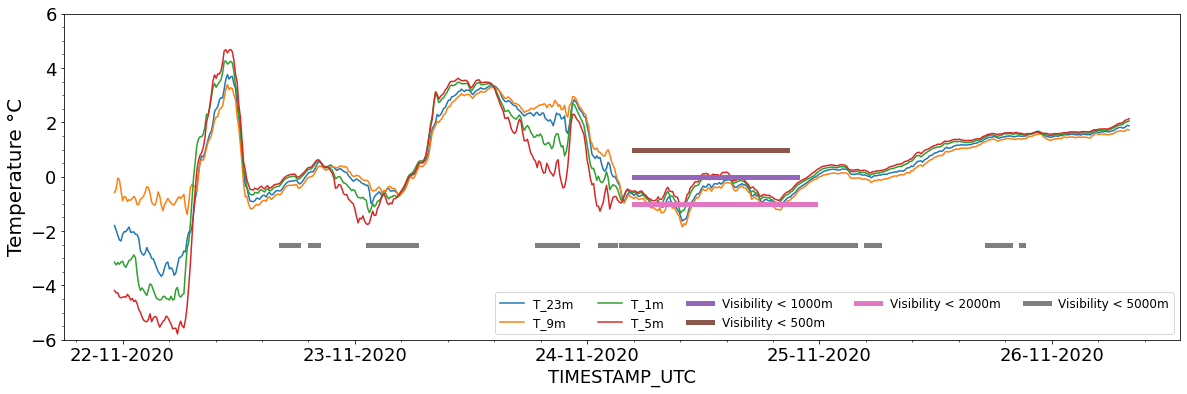

In [198]:
fig, ax = plt.subplots(1)
plt.rcParams["figure.figsize"] = (20,6)

ax.plot(combined_temp_nov['temp_Avg(1)'][170:800], label = 'T_23m')
ax.plot(combined_temp_nov['temp_Avg(2)'][170:800], label = 'T_9m')
#ax.plot(combined_temp['T'][0:600 -1], label = 'Rh_2m(HMS)')
ax.plot(combined_temp_nov['AirTC_1_Avg'][170:800], label = 'T_1m')
ax.plot(combined_temp_nov['AirTC_2_Avg'][170:800], label = 'T_5m')
#
#
## visibility
#
#
ax.plot(combined_temp_nov['Vis_1000'][170:800], linewidth=5, label = 'Visibility < 1000m')
ax.plot(combined_temp_nov['Vis_500'][170:800], linewidth=5, label = 'Visibility < 500m')
ax.plot(combined_temp_nov['Vis_2000'][170:800], linewidth=5, label = 'Visibility < 2000m')
ax.plot(combined_temp_nov['Vis_5000'][170:800], linewidth=5, label = 'Visibility < 5000m')

ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=8)
ax.tick_params(axis='x', labelrotation=0)

ax.set_ylim([-6,6])
ax.legend(loc= 'lower right', prop={'size': 12}, ncol = 5)
ax.set_xlabel('TIMESTAMP_UTC', fontsize=18)
ax.set_ylabel('Temperature \N{DEGREE SIGN}C', fontsize=20)
fig.set_size_inches(20, 6)

ax.xaxis.set_major_locator(DayLocator())
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%Y"))

ax.minorticks_on()

In [199]:
wind_garden = pd.read_csv('/Volumes/Seagate Backup Plus Drive/data_exp1/Wind_garden.csv')
wind_garden.head()

,TIMESTAMP,RECORD,mean_wind_speed,mean_wind_direction,std_wind_dir,samples_TOT,diag_1_TOT,diag_2_TOT,diag_4_TOT,diag_8_TOT,...,wind_speed_2_Min,wind_speed_2_TMn,wind_speed_2_Max,wind_speed_2_TMx,wind_speed_2_Std,wind_direction_2_Min,wind_direction_2_TMn,wind_direction_2_Max,wind_direction_2_TMx,wind_direction_2_Std
0,2020-12-29 14:56:00,55947.0,2.054667,166.2462,18.00956,30,0,0,0,0,...,1.06,2020-12-29 14:55:38,3.29,2020-12-29 14:55:04,0.602,144,2020-12-29 14:55:12,250,2020-12-29 14:55:04,24.76
1,2020-12-29 14:57:00,55948.0,2.139333,189.0804,28.55266,30,0,0,0,0,...,0.63,2020-12-29 14:56:08,3.14,2020-12-29 14:56:56,0.701,141,2020-12-29 14:56:24,238,2020-12-29 14:56:58,26.26
2,2020-12-29 14:58:00,55949.0,2.014667,168.6094,21.88021,30,0,0,0,0,...,0.31,2020-12-29 14:57:42,3.55,2020-12-29 14:58:00,0.689,133,2020-12-29 14:57:56,232,2020-12-29 14:57:02,24.61
3,2020-12-29 14:59:00,55950.0,2.428333,163.9234,25.91584,30,0,0,0,0,...,0.46,2020-12-29 14:58:42,3.51,2020-12-29 14:58:10,0.762,105,2020-12-29 14:58:44,201,2020-12-29 14:58:34,20.92
4,2020-12-29 15:00:00,55951.0,2.915333,176.1959,21.95110,30,0,0,0,0,...,1.10,2020-12-29 14:59:54,4.24,2020-12-29 14:59:34,0.857,140,2020-12-29 14:59:10,211,2020-12-29 14:59:52,20.11


In [200]:
print(wind_garden.columns)
c = wind_garden.iloc[:, 0:5]
d = wind_garden.iloc[:,24:27 ]
wind_garden = pd.concat([c,d], axis = 1)
wind_garden.columns

Index(['TIMESTAMP', 'RECORD', 'mean_wind_speed', 'mean_wind_direction',
       'std_wind_dir', 'samples_TOT', 'diag_1_TOT', 'diag_2_TOT', 'diag_4_TOT',
       'diag_8_TOT', 'diag_9_TOT', 'diag_10_TOT', 'nnd_TOT',
       'checksum_err_TOT', 'wind_speed_1_Min', 'wind_speed_1_TMn',
       'wind_speed_1_Max', 'wind_speed_1_TMx', 'wind_speed_1_Std',
       'wind_direction_1_Min', 'wind_direction_1_TMn', 'wind_direction_1_Max',
       'wind_direction_1_TMx', 'wind_direction_1_Std', 'mean_wind_speed_2',
       'mean_wind_direction_2', 'std_wind_dir_2', 'samples_TOT_2',
       'diag_1_TOT_2', 'diag_2_TOT_2', 'diag_4_TOT_2', 'diag_8_TOT_2',
       'diag_9_TOT_2', 'diag_10_TOT_2', 'nnd_TOT_2', 'checksum_err_TOT_2',
       'wind_speed_2_Min', 'wind_speed_2_TMn', 'wind_speed_2_Max',
       'wind_speed_2_TMx', 'wind_speed_2_Std', 'wind_direction_2_Min',
       'wind_direction_2_TMn', 'wind_direction_2_Max', 'wind_direction_2_TMx',
       'wind_direction_2_Std'],
      dtype='object')


Index(['TIMESTAMP', 'RECORD', 'mean_wind_speed', 'mean_wind_direction',
       'std_wind_dir', 'mean_wind_speed_2', 'mean_wind_direction_2',
       'std_wind_dir_2'],
      dtype='object')

In [201]:
wind_garden = wind_garden.iloc[4:,:]
wind_garden = wind_garden.reset_index()
wind_garden

,index,TIMESTAMP,RECORD,mean_wind_speed,mean_wind_direction,std_wind_dir,mean_wind_speed_2,mean_wind_direction_2,std_wind_dir_2
0,4,2020-12-29 15:00:00,55951.0,2.915333,176.1959,21.95110,2.457333,177.2909,20.13798
1,5,2020-12-29 15:01:00,55952.0,2.671333,157.5438,31.08230,1.663667,169.0774,39.40593
2,6,2020-12-29 15:02:00,55953.0,2.640000,175.0389,19.97102,1.640000,188.4323,32.88135
3,7,2020-12-29 15:03:00,55954.0,3.089333,165.1851,13.34287,3.064667,167.3214,22.48519
4,8,2020-12-29 15:04:00,55955.0,3.314000,180.0971,23.62538,2.510666,181.7190,23.62369
...,...,...,...,...,...,...,...,...,...
181297,181301,2021-05-04 12:46:00,237248.0,4.609334,191.7484,22.00977,3.587667,190.2069,24.87383
181298,181302,2021-05-04 12:47:00,237249.0,2.402833,194.4445,29.40389,2.316833,181.0916,23.02179
181299,181303,2021-05-04 12:48:00,237250.0,2.322204,192.3430,28.03742,1.618833,195.9572,38.65234
181300,181304,2021-05-04 12:49:00,237251.0,2.889500,207.6853,39.52168,2.001167,196.3538,47.58656


In [202]:
wind_garden['TIMESTAMP'] = pd.to_datetime(wind_garden['TIMESTAMP'])
wind_garden

,index,TIMESTAMP,RECORD,mean_wind_speed,mean_wind_direction,std_wind_dir,mean_wind_speed_2,mean_wind_direction_2,std_wind_dir_2
0,4,2020-12-29 15:00:00,55951.0,2.915333,176.1959,21.95110,2.457333,177.2909,20.13798
1,5,2020-12-29 15:01:00,55952.0,2.671333,157.5438,31.08230,1.663667,169.0774,39.40593
2,6,2020-12-29 15:02:00,55953.0,2.640000,175.0389,19.97102,1.640000,188.4323,32.88135
3,7,2020-12-29 15:03:00,55954.0,3.089333,165.1851,13.34287,3.064667,167.3214,22.48519
4,8,2020-12-29 15:04:00,55955.0,3.314000,180.0971,23.62538,2.510666,181.7190,23.62369
...,...,...,...,...,...,...,...,...,...
181297,181301,2021-05-04 12:46:00,237248.0,4.609334,191.7484,22.00977,3.587667,190.2069,24.87383
181298,181302,2021-05-04 12:47:00,237249.0,2.402833,194.4445,29.40389,2.316833,181.0916,23.02179
181299,181303,2021-05-04 12:48:00,237250.0,2.322204,192.3430,28.03742,1.618833,195.9572,38.65234
181300,181304,2021-05-04 12:49:00,237251.0,2.889500,207.6853,39.52168,2.001167,196.3538,47.58656


In [203]:
wind_garden = wind_garden.resample('10min', closed = 'left', on = 'TIMESTAMP').mean()
wind_garden

,index,RECORD,mean_wind_speed,mean_wind_direction,std_wind_dir,mean_wind_speed_2,mean_wind_direction_2,std_wind_dir_2
TIMESTAMP,,,,,,,,
2020-12-29 15:00:00,8.5,55955.5,2.858233,174.337810,21.215813,2.240667,180.119920,27.007592
2020-12-29 15:10:00,17.0,55964.0,3.585793,171.432686,18.980857,2.618183,179.809729,21.233058
2020-12-29 15:20:00,25.5,55972.5,2.795567,174.082770,20.270364,2.197933,179.043770,24.142398
2020-12-29 15:30:00,35.5,55982.5,2.847833,177.223780,25.780331,2.172233,182.686010,23.519851
2020-12-29 15:40:00,45.5,55992.5,2.292767,171.580500,21.076157,1.717233,174.559930,23.615187
...,...,...,...,...,...,...,...,...
2021-05-04 12:10:00,181269.5,237216.5,3.074818,208.562550,25.883937,2.402133,204.375900,35.100595
2021-05-04 12:20:00,181279.5,237226.5,3.414333,191.349830,26.750484,2.782650,194.419590,31.430996
2021-05-04 12:30:00,181289.5,237236.5,3.524383,197.197950,24.350404,2.657515,199.885990,26.556800


In [204]:
wind_garden['TIMESTAMP(UTCplus2)'] = wind_garden.index
#wind_garden
wind_garden = wind_garden[(wind_garden['TIMESTAMP(UTCplus2)'] >= '2021-02-01 00:00:00') & 
                        (wind_garden['TIMESTAMP(UTCplus2)'] <= '2021-04-07 14:20:00')]
wind_garden

,index,RECORD,mean_wind_speed,mean_wind_direction,std_wind_dir,mean_wind_speed_2,mean_wind_direction_2,std_wind_dir_2,TIMESTAMP(UTCplus2)
TIMESTAMP,,,,,,,,,
2021-02-01 00:00:00,48065.5,104012.5,0.476267,248.538176,6.802079,0.243467,56.754357,21.817073,2021-02-01 00:00:00
2021-02-01 00:10:00,48075.5,104022.5,0.311900,193.395530,14.169140,0.150367,147.172932,28.717396,2021-02-01 00:10:00
2021-02-01 00:20:00,48085.5,104032.5,0.242167,192.430401,13.166445,0.210567,187.022350,27.063741,2021-02-01 00:20:00
2021-02-01 00:30:00,48095.5,104042.5,0.404133,99.903572,17.310437,0.236200,102.689205,24.704982,2021-02-01 00:30:00
2021-02-01 00:40:00,48105.5,104052.5,0.861833,248.969057,10.639193,0.280333,274.256308,24.586524,2021-02-01 00:40:00
...,...,...,...,...,...,...,...,...,...
2021-04-07 13:40:00,142479.5,198426.5,3.911200,291.755650,16.488969,3.154933,295.975520,21.310385,2021-04-07 13:40:00
2021-04-07 13:50:00,142489.5,198436.5,4.523767,284.087320,15.676965,3.436644,290.475580,18.048607,2021-04-07 13:50:00
2021-04-07 14:00:00,142499.5,198446.5,3.778576,304.138620,15.997899,3.247067,306.718810,17.360434,2021-04-07 14:00:00


In [205]:
wind_garden = wind_garden.reset_index()
wind_garden = wind_garden.iloc[:, 2:]

In [206]:
wind_garden.columns

Index(['RECORD', 'mean_wind_speed', 'mean_wind_direction', 'std_wind_dir',
       'mean_wind_speed_2', 'mean_wind_direction_2', 'std_wind_dir_2',
       'TIMESTAMP(UTCplus2)'],
      dtype='object')

In [207]:
temp_gill.columns

Index(['index', 'TIMESTAMP', 'RECORD', 'PTemp_Avg', 'Batt_volt_Avg',
       'rh_Avg(1)', 'rh_Avg(2)', 'temp_Avg(1)', 'temp_Avg(2)', 'ws_Avg(1)',
       'ws_Avg(2)', 'ws_Std(1)', 'ws_Std(2)'],
      dtype='object')

In [208]:
temp_garden.columns

Index(['TIMESTAMP(UTC+2)', 'RECORD', 'AirTC_1_Avg', 'RH_1', 'AirTC_2_Avg',
       'RH_2', 'TIMESTAMP(UTCplus2)'],
      dtype='object')

In [209]:
wind_gill_f = temp_gill_f[['TIMESTAMP', 'ws_Avg(1)', 'ws_Avg(2)', 'ws_Std(1)', 'ws_Std(2)']]

In [210]:
wind_garden_f = wind_garden.iloc[11 : len(wind_garden['RECORD']), :]

wind_garden_f = wind_garden_f.reset_index()

In [211]:
combined_wind = pd.concat([wind_gill_f, wind_garden_f, synop_temp], axis = 1)

In [212]:
combined_wind.columns

Index(['TIMESTAMP', 'ws_Avg(1)', 'ws_Avg(2)', 'ws_Std(1)', 'ws_Std(2)',
       'index', 'RECORD', 'mean_wind_speed', 'mean_wind_direction',
       'std_wind_dir', 'mean_wind_speed_2', 'mean_wind_direction_2',
       'std_wind_dir_2', 'TIMESTAMP(UTCplus2)', 'level_0', 'index',
       'Time (CET)', 'V', 'U', 'T', 'FS'],
      dtype='object')

In [240]:
def visibility(lower_value, upper_value,value):
    list_empty = []
    for i in range(len(combined_wind['V'])):
        if combined_wind['V'][i] >= lower_value and combined_wind['V'][i] <= upper_value:
            list_empty.append(value)
        
        else:
            list_empty.append(float('NAN'))
            
    return list_empty

Vis_1000 = visibility( 0, 1000, 1.0)
Vis_500 = visibility( 0, 500, 1.2)
Vis_2000 = visibility( 0, 2000, 0.8)
Vis_5000 = visibility( 0, 5000, 0.5)
combined_wind['Vis_1000'] = Vis_1000
combined_wind['Vis_2000'] = Vis_2000
combined_wind['Vis_5000'] = Vis_5000
combined_wind['Vis_500'] = Vis_500

In [214]:
combined_wind = combined_wind.set_index(combined_wind['TIMESTAMP'])

In [215]:
x = combined_wind['ws_Avg(1)'].to_numpy()   # checking cross correlation
y = combined_wind['mean_wind_direction'].to_numpy()
len(x)
xx = x[400:800]
yy = y[400:800]
shift = sm.tsa.stattools.ccf(xx, yy, adjusted=False)
np.argmax(shift)

0

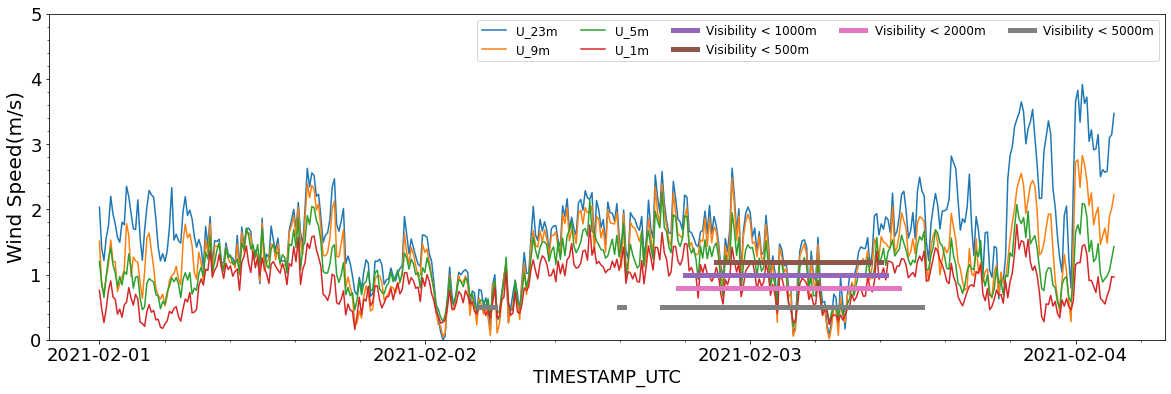

In [244]:
fig, ax = plt.subplots(1)
plt.rcParams["figure.figsize"] = (20,6)

ax.plot(combined_wind['ws_Avg(1)'][0:450], label = 'U_23m')
ax.plot(combined_wind['ws_Avg(2)'][0:450], label = 'U_9m')
#ax.plot(combined_wind['FS'][0:450], label = 'U_2m(HMS)')
ax.plot(combined_wind['mean_wind_speed'][0:450], label = 'U_5m')
ax.plot(combined_wind['mean_wind_speed_2'][0:450], label = 'U_1m')

#visibility

ax.plot(combined_wind['Vis_1000'][0:450], linewidth=5, label = 'Visibility < 1000m')
ax.plot(combined_wind['Vis_500'][0:450], linewidth=5, label = 'Visibility < 500m')
ax.plot(combined_wind['Vis_2000'][0:450], linewidth=5, label = 'Visibility < 2000m')
ax.plot(combined_wind['Vis_5000'][0:450], linewidth=5, label = 'Visibility < 5000m')
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=8)
ax.tick_params(axis='x', labelrotation= 0)

ax.set_ylim([0,5])
ax.legend(loc= 'upper right', prop={'size': 12}, ncol = 5)
ax.set_xlabel('TIMESTAMP_UTC', fontsize=18)
ax.set_ylabel('Wind Speed(m/s)', fontsize=20)
fig.set_size_inches(20, 6)

ax.xaxis.set_major_locator(DayLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))

ax.minorticks_on()

In [217]:
wind_gill_nov_f = temp_gill_novf[['TIMESTAMP', 'ws_Avg(1)', 'ws_Avg(2)', 'ws_Std(1)', 'ws_Std(2)']]

In [218]:
wind_garden_nov = pd.read_excel('/Volumes/Seagate Backup Plus Drive/data_exp1/TOA5_5671.Wind.xlsx', skiprows= 1)


In [219]:
e = wind_garden_nov.iloc[:, 0:5]
f = wind_garden_nov.iloc[:, 24:27]
wind_garden_nov = pd.concat([e,f], axis = 1)
wind_garden_nov

,TIMESTAMP,RECORD,mean_wind_speed,mean_wind_direction,std_wind_dir,mean_wind_speed_2,mean_wind_direction_2,std_wind_dir_2
0,TS,RN,m/s,Deg,Deg,m/s,Deg,Deg
1,NaN,NaN,WVc,WVc,WVc,WVc,WVc,WVc
2,2020-11-20 18:22:00,0,NAN,NAN,NAN,NAN,NAN,NAN
3,2020-11-20 18:23:00,1,NAN,NAN,NAN,NAN,NAN,NAN
4,2020-11-20 18:24:00,2,NAN,NAN,NAN,NAN,NAN,NAN
...,...,...,...,...,...,...,...,...
17095,2020-12-02 15:22:00,17093,3.064,67.94904,14.46979,2.429667,74.27493,18.96407
17096,2020-12-02 15:23:00,17094,1.423,82.6814,17.001,1.243,78.7662,18.49629
17097,2020-12-02 15:24:00,17095,1.595,79.67412,16.8059,0.991333,85.38309,25.25295
17098,2020-12-02 15:25:00,17096,2.290667,68.74907,18.31558,1.543333,76.64539,31.27514


In [220]:
wind_garden_nov = wind_garden_nov[23:]
wind_garden_nov = wind_garden_nov.reset_index()

In [221]:
wind_garden_nov['TIMESTAMP'] = pd.to_datetime(wind_garden_nov['TIMESTAMP'])
#wind_garden_nov


In [222]:
wind_garden_nov.columns

Index(['index', 'TIMESTAMP', 'RECORD', 'mean_wind_speed',
       'mean_wind_direction', 'std_wind_dir', 'mean_wind_speed_2',
       'mean_wind_direction_2', 'std_wind_dir_2'],
      dtype='object')

In [223]:
wind_garden_nov = wind_garden_nov[[ 'TIMESTAMP',
                            'mean_wind_speed',
                          'mean_wind_direction', 'std_wind_dir', 
                           'mean_wind_speed_2', 'mean_wind_direction_2',
                                  'std_wind_dir_2']].resample('10min', on = 'TIMESTAMP').mean()
#wind_garden = wind_garden.resample('10min', closed = 'left', on = 'TIMESTAMP').mean()


In [224]:
#wind_garden_nov
wind_garden_nov = wind_garden_nov.rename_axis('TIMESTAMP(UTC+2)').reset_index() ## resettin the index

In [225]:
wind_garden_novf = wind_garden_nov.iloc[11:len(wind_garden_nov['TIMESTAMP(UTC+2)']), :]
wind_garden_novf.reset_index(inplace = True)
del wind_garden_novf['TIMESTAMP']

In [226]:
combined_wind_nov = pd.concat([wind_gill_nov_f, wind_garden_novf, synop_temp_nov], axis = 1)
combined_wind_nov = combined_wind_nov.set_index(combined_wind_nov['TIMESTAMP'])

In [227]:
def visibility(lower_value, upper_value,value):
    list_empty = []
    for i in range(len(combined_wind_nov['V'])):
        if combined_wind_nov['V'][i] >= lower_value and combined_wind_nov['V'][i] <= upper_value:
            list_empty.append(value)
        
        else:
            list_empty.append(float('NAN'))
            
    return list_empty

Vis_1000 = visibility( 0, 1000, 1.5)
Vis_500 = visibility( 0, 500, 2)
Vis_2000 = visibility( 0, 2000, 1)
Vis_5000 = visibility( 0, 5000, 0.5)
combined_wind_nov['Vis_1000'] = Vis_1000
combined_wind_nov['Vis_2000'] = Vis_2000
combined_wind_nov['Vis_5000'] = Vis_5000
combined_wind_nov['Vis_500'] = Vis_500

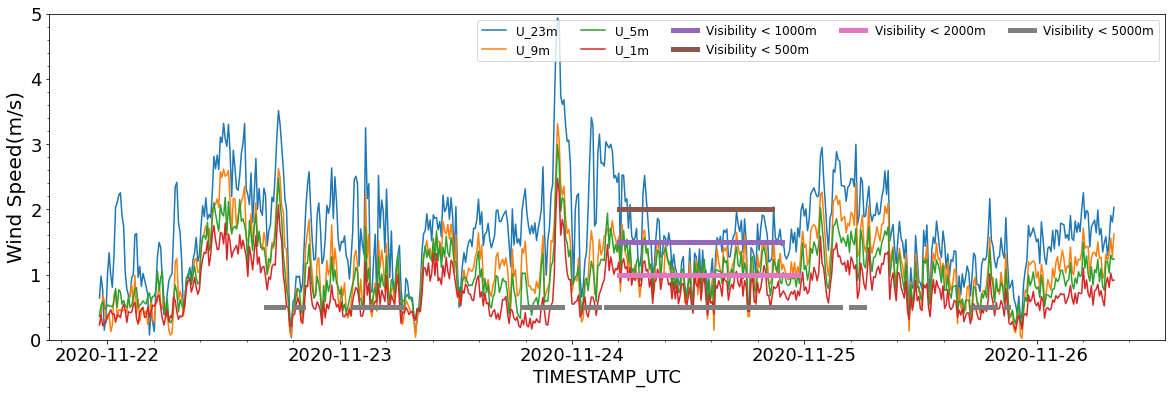

In [243]:
fig, ax = plt.subplots(1)
plt.rcParams["figure.figsize"] = (20,6)

ax.plot(combined_wind_nov['ws_Avg(1)'][170:800], label = 'U_23m')
ax.plot(combined_wind_nov['ws_Avg(2)'][170:800], label = 'U_9m')

#ax.plot(combined_wind_nov['FS'][0:1300], label = 'T_9m')


ax.plot(combined_wind_nov['mean_wind_speed'][170:800], label = 'U_5m')
ax.plot(combined_wind_nov['mean_wind_speed_2'][170:800], label = 'U_1m')




ax.plot(combined_wind_nov['Vis_1000'][170:800], linewidth=5, label = 'Visibility < 1000m')
ax.plot(combined_wind_nov['Vis_500'][170:800], linewidth=5, label = 'Visibility < 500m')
ax.plot(combined_wind_nov['Vis_2000'][170:800], linewidth=5, label = 'Visibility < 2000m')
ax.plot(combined_wind_nov['Vis_5000'][170:800], linewidth=5, label = 'Visibility < 5000m')

ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=8)
ax.tick_params(axis='x', labelrotation=0)

ax.set_ylim([0,5])
ax.legend(loc= 'upper right', prop={'size': 12}, ncol = 5)

ax.set_xlabel('TIMESTAMP_UTC', fontsize=18)
ax.set_ylabel('Wind Speed(m/s)', fontsize=20)
#fig.set_size_inches(20, 6)


ax.xaxis.set_major_locator(DayLocator())
ax.xaxis.set_major_formatter(DateFormatter("%Y-%m-%d"))

ax.minorticks_on()

In [137]:
combined_wind_nov.columns

Index(['TIMESTAMP', 'ws_Avg(1)', 'ws_Avg(2)', 'ws_Std(1)', 'ws_Std(2)',
       'index', 'TIMESTAMP(UTC+2)', 'mean_wind_speed', 'mean_wind_direction',
       'std_wind_dir', 'mean_wind_speed_2', 'mean_wind_direction_2',
       'std_wind_dir_2', 'level_0', 'index', 'Time (CET)', 'V', 'U', 'T', 'FS',
       'Vis_1000', 'Vis_2000', 'Vis_5000', 'Vis_500'],
      dtype='object')